In [18]:
from backend.utils.ifa_meander_project_v2.geometry import *
from backend.utils.ifa_meander_project_v2.meshing import *
from backend.utils.ifa_meander_project_v2.frequency import *
from backend.utils.ifa_meander_project_v2.simulation import *
from backend.utils.gmsh_function import extract_msh_to_mat
from backend.efield.efield4 import plot_s11_curve, plot_s11_curve_MoM_vs_Experiment, plot_s11_curve_CST_MoM, calculate_bandwidth

In [19]:

# Define frequency range configurations after ratio > 0.33
"""fLow = 420e6
fHigh = 450e6
fC = 433e6
step = 0.1e6"""

# define frequency range configurations before ratio < 0.33
fLow = 400e6
fHigh = 466e6
fC = 433e6
step = 0.1e6

"""fLow = 373e6
fHigh = 490e6
fC = 433e6
step = 10e6"""

frequencies, fc_index, nPoints = generate_frequencies_2(fLow, fHigh, fC, step)

print(f"Number of frequencies (nPoints) : {nPoints}")
print(f"Index of fC : {fc_index}")

Number of frequencies (nPoints) : 661
Index of fC : 330


In [20]:
mesh_name = "sim_optimize_ifa.msh"
geometry_name_ifa_meander = "sim_optimize_ifa.step"
geometry_name_ifa_meander_for_CST = "sim_optimize_ifa_for_CST.step"
save_mesh_folder = 'data/gmsh_files/'
ifa_meander_mat = 'data/antennas_mesh/sim_optimize_ifa.mat'
ifa_meander_msh = save_mesh_folder + mesh_name

In [21]:
import json


ratio = 0.42222
filename_log = f"data/log_optimization/optimization_results_{ratio}.json"

# Load the parameters from the JSON file
with open(filename_log, 'r') as f:
    params = json.load(f)

# Extract parameters (stored in meters)
a = params["a"]
largeur_piste = params["largeur_piste"]
distance_meandre = params["distance_meandre"]
feed = params["feed"]
mesh_size = params["mesh_size"]

# Print values converted to millimeters
print(f"a = {a * 1000:.3f} mm")
print(f"largeur_piste = {largeur_piste * 1000:.3f} mm")
print(f"distance_meandre = {distance_meandre * 1000:.3f} mm")
print(f"feed = {feed * 1000:.3f} mm")
print(f"Mesh size : {mesh_size * 1000:.2f} mm")


a = 38.000 mm
largeur_piste = 2.639 mm
distance_meandre = 2.639 mm
feed = 53.505 mm
Mesh size : 8.14 mm


In [22]:
terminal_a = 90 / 1000              # height of the terminal
terminal_b = 60 / 1000                 # width of the terminal
x_t = np.array([-terminal_a + a, 0, 0, -terminal_a + a])
y_t = np.array([terminal_b, terminal_b, 0, 0])

feed_point = np.array([0, feed, 0])

"""# Fix the short feed and the track width
if terminal_b / a > 2:
    mesh = a / 12          # Minimum value
else:
    mesh = a / 20          # Minimum value"""

"""mesh = a / 10          # Minimum value

mesh_size = mesh * 4 """                        # ratio if ratio <= 0.33
# mesh_size = (2.2 + terminal_b / a) * mesh  # ratio if ratio > 0.33
# mesh_size = (2.2 + terminal_b / a) * mesh

# print(f"Mesh size : {mesh_size * 1000:.2f} mm")

'mesh = a / 10          # Minimum value\n\nmesh_size = mesh * 4 '

In [ ]:
def creation_ifa(largeur, hauteur, width, dist_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size):
    x, y, N, distance_meandre = ifa_creation(largeur, hauteur, width, dist_meandre)
    x_m, y_m = trace_meander(x, y, width)
    feed_wid = width # The track width is the same everywhere
    feed_x = np.array([0, distance_meandre, distance_meandre, 0])
    feed_y = np.array([feed + feed_wid/2, feed + feed_wid/2, feed -feed_wid/2, feed - feed_wid/2])
    antenna_ifa_meander(x_m, y_m, x_t, y_t, feed_x, feed_y, save_mesh_folder, mesh_name, mesh_size, geometry_name=geometry_name_ifa_meander)
    extract_msh_to_mat(ifa_meander_msh, ifa_meander_mat)

    # This part is to export the geometry for CST
    shift_feed = 1e-3 # 0.5 mm shift
    feed_y_shifted = feed_y - shift_feed
    Gap_distance = 0.5e-3  # 0.5 mm gap between meander and terminal
    feed_x_shifted = feed_x[0] + Gap_distance, feed_x[1], feed_x[2], feed_x[3] + Gap_distance
    antenna_ifa_meander_for_CST(x_m, y_m, x_t, y_t, feed_x_shifted, feed_y_shifted, save_mesh_folder, mesh_size, geometry_name=geometry_name_ifa_meander_for_CST)
    return N, distance_meandre

In [24]:
Z_adapt = 25

In [25]:
print(f"distance meandres {distance_meandre * 1000} mm")
print(f"IFA track width {largeur_piste * 1000} mm")
print(f"feed position = {feed * 1000} mm\n")

# Create the IFA antenna with meander
N_list_elem, new_distance_meandre_elem = creation_ifa(a, terminal_b, largeur_piste, distance_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size)

print(f"\nNumber of meanders {N_list_elem}")
print(f"New meander distance {new_distance_meandre_elem * 1000} mm")

distance meandres 2.6386209043450677 mm
IFA track width 2.6386209043450677 mm
feed position = 53.505421326386916 mm

[OK] Geometry exported (scaled by ×1000.0) → data/gmsh_files/sim_optimize_ifa_for_CST.step

Number of meanders 7
New meander distance 2.7899219527977897 mm


Simulation 1/661 | f = 400.00 MHz | S11 = -0.09 dB
Simulation 2/661 | f = 400.10 MHz | S11 = -0.09 dB
Simulation 3/661 | f = 400.20 MHz | S11 = -0.10 dB
Simulation 4/661 | f = 400.30 MHz | S11 = -0.10 dB
Simulation 5/661 | f = 400.40 MHz | S11 = -0.10 dB
Simulation 6/661 | f = 400.50 MHz | S11 = -0.10 dB
Simulation 7/661 | f = 400.60 MHz | S11 = -0.10 dB
Simulation 8/661 | f = 400.70 MHz | S11 = -0.10 dB
Simulation 9/661 | f = 400.80 MHz | S11 = -0.10 dB
Simulation 10/661 | f = 400.90 MHz | S11 = -0.10 dB
Simulation 11/661 | f = 401.00 MHz | S11 = -0.10 dB
Simulation 12/661 | f = 401.10 MHz | S11 = -0.10 dB
Simulation 13/661 | f = 401.20 MHz | S11 = -0.10 dB
Simulation 14/661 | f = 401.30 MHz | S11 = -0.10 dB
Simulation 15/661 | f = 401.40 MHz | S11 = -0.10 dB
Simulation 16/661 | f = 401.50 MHz | S11 = -0.10 dB
Simulation 17/661 | f = 401.60 MHz | S11 = -0.11 dB
Simulation 18/661 | f = 401.70 MHz | S11 = -0.11 dB
Simulation 19/661 | f = 401.80 MHz | S11 = -0.11 dB
Simulation 20/661 | f

Simulation 331/661 | f = 433.00 MHz | S11 = -12.61 dB
Simulation 332/661 | f = 433.10 MHz | S11 = -13.14 dB
Simulation 333/661 | f = 433.20 MHz | S11 = -13.70 dB
Simulation 334/661 | f = 433.30 MHz | S11 = -14.28 dB
Simulation 335/661 | f = 433.40 MHz | S11 = -14.89 dB
Simulation 336/661 | f = 433.50 MHz | S11 = -15.51 dB
Simulation 337/661 | f = 433.60 MHz | S11 = -16.15 dB
Simulation 338/661 | f = 433.70 MHz | S11 = -16.78 dB
Simulation 339/661 | f = 433.80 MHz | S11 = -17.39 dB
Simulation 340/661 | f = 433.90 MHz | S11 = -17.95 dB
Simulation 341/661 | f = 434.00 MHz | S11 = -18.42 dB
Simulation 342/661 | f = 434.10 MHz | S11 = -18.75 dB
Simulation 343/661 | f = 434.20 MHz | S11 = -18.91 dB
Simulation 344/661 | f = 434.30 MHz | S11 = -18.89 dB
Simulation 345/661 | f = 434.40 MHz | S11 = -18.68 dB
Simulation 346/661 | f = 434.50 MHz | S11 = -18.31 dB
Simulation 347/661 | f = 434.60 MHz | S11 = -17.82 dB
Simulation 348/661 | f = 434.70 MHz | S11 = -17.25 dB
Simulation 349/661 | f = 434


📡 Simulation results:
→ Resonance frequency = 434.20 MHz
→ Impedance at f_res  = 23.20+5.19j Ω
frequency resonance / S11 min = 434.20 MHz / -18.91 dB
s


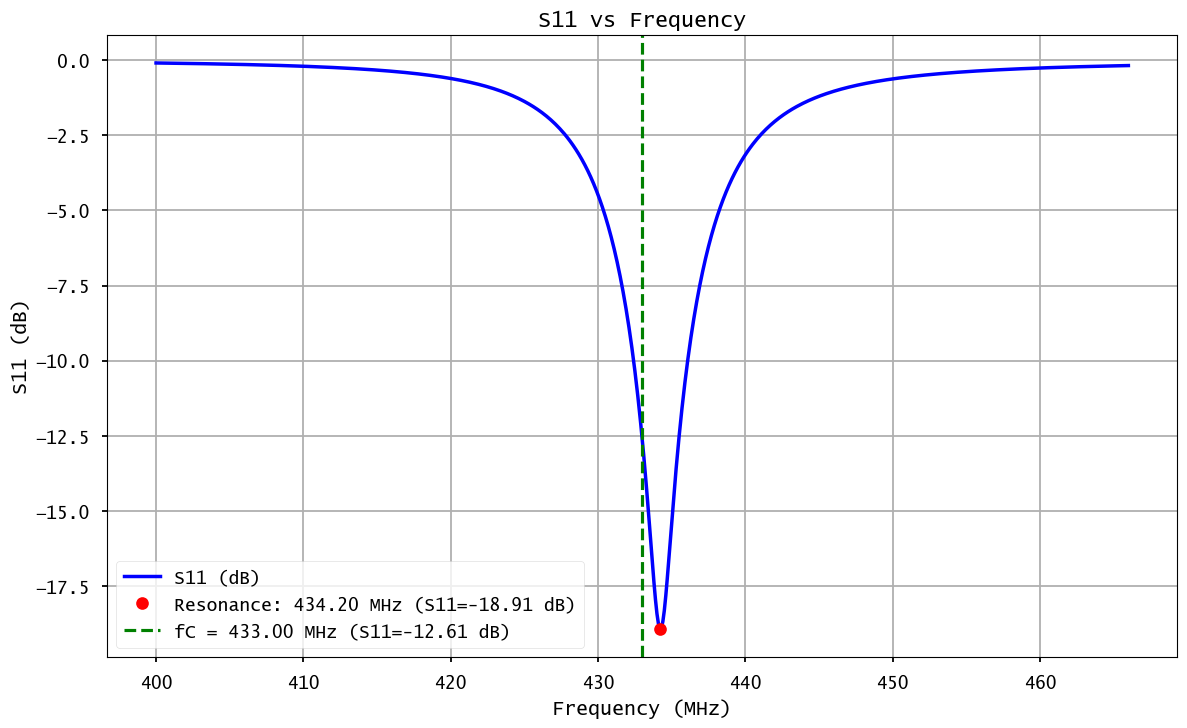


🔹 Bandwidth: 6.60 MHz
   - f_min = 0.431 GHz
   - f_max = 0.438 GHz
   - Threshold = -6 dB



(np.float64(6.6), np.float64(431000000.0), np.float64(437600000.0))

In [26]:
# Simulate S11 and impedance at feed point
_, s11_db, _, _, impedances_simulated = simulate_433_project(frequencies, ifa_meander_mat, fC, feed_point, Z0=Z_adapt)

# Plot S11 curve
plot_s11_curve(s11_db, fLow, fHigh, fC, show_min=True)

calculate_bandwidth(frequencies, s11_db, threshold=-6)

In [ ]:
# ============================================================================
# FUNCTIONS
# ============================================================================

def add_series_capacitor(impedances, frequencies, C):
    """Add series capacitor to impedances"""
    frequencies = np.array(frequencies)  # Ensure frequencies is a numpy array
    impedances = np.array(impedances)    # Ensure impedances is a numpy array
    X_cap = -1 / (2 * np.pi * frequencies * C)  # Capacitive reactance
    Z_cap = 1j * X_cap
    return impedances + Z_cap

def add_parallel_capacitor_inductor(impedances, frequencies, C, L):
    frequencies = np.array(frequencies)  # Ensure frequencies is a numpy array
    impedances = np.array(impedances)    # Ensure impedances is a numpy array

    # Admittance of the inductor and capacitor
    Y_L = 1 / (1j * 2 * np.pi * frequencies * L)  # Admittance of inductor
    Y_C = 1j * 2 * np.pi * frequencies * C        # Admittance of capacitor

    # antenna admittance
    Y_ant = 1 / impedances

    # Total admittance
    Y_total = Y_ant + Y_L + Y_C

    # Convert back to impedance
    Z_total = 1 / Y_total

    return Z_total

def add_shunt_capacitor(impedances, frequencies, C):
    """Add series capacitor to impedances"""
    """frequencies = np.array(frequencies)  # Ensure frequencies is a numpy array
    impedances = np.array(impedances)    # Ensure impedances is a numpy array"""
    # Admittance de l'antenne
    Y_ant = 1 / impedances

    # Admittance de la capacité shunt
    Y_cap = 1j * 2 * np.pi * frequencies * C

    # Admittance totale (on additionne les admittances en parallèle)
    Y_total = Y_ant + Y_cap

    # Conversion en impédance
    return 1 / Y_total

def calculate_s11_db(impedance, z0):
    """Calculate S11 in dB from impedance"""
    s11 = (impedance - z0) / (impedance + z0)
    s11_db = 20 * np.log10(np.abs(s11))
    return s11_db, s11


iterations = 1
freq_calculation = fC # Frequency at which we want to match
# loop to vary L and calculate C for matching at fC
# 0.08, 0.22, 0.005 
for L_nH in np.arange(0.21, 0.24, 0.002):

    text = f"                                                                   Iteration {iterations}                                                                   "
    line = "=" * len(text)
    print(f"\n{line}\n{text}\n{line}")

    iterations += 1
    L_H = L_nH * 1e-9  # Convert to Henry
    # formula to find C_pF
    C_F = 1 / ((2 * np.pi * freq_calculation)**2 * L_H)  # in Farads
    print(f"L = {L_H*1e9:.4f} nH\nC = {C_F*1e12:.4f} pF")

    # Add series capacitor
    # impedances_matched = add_series_capacitor(last_impedances, frequencies, C_F)
    impedances_matched = add_parallel_capacitor_inductor(impedances_simulated, frequencies, C_F, L_H)

    # Calculate matched S11
    s11_db_matched, s11_matched = calculate_s11_db(impedances_matched, z0=Z_adapt)
    plot_s11_curve(s11_db_matched, fLow, fHigh, fC, show_min=True, s11_reference=-6, show_reference=True)
    plot_smith_chart(impedances_matched, frequencies, fC, Z0=Z_adapt)
    calculate_bandwidth(frequencies, s11_db_matched, threshold=-6)
    


# put inductance and capacitance to make double tuning matching

# loop to vary L and calculate C for matching at fC

iterations = 1

for C_pF in np.arange(800, 1300, 100):
    print(f"\n--- Iteration {iterations} ---")
    iterations += 1
    C_F = C_pF * 1e-12  # Convert to Farads
    # formula to find L_nF
    L_H = 1 / ((2 * np.pi * fC)**2 * C_F)  # in Henry
    print(f"C = {C_pF:.2f} pF, L = {L_H*1e9:.2f} nH")

    # Add series capacitor
    # impedances_matched = add_series_capacitor(last_impedances, frequencies, C_F)
    impedances_matched = add_parallel_capacitor_inductor(impedances_simulated, frequencies, C_F, L_H)

    # Calculate matched S11
    s11_db_matched, s11_matched = calculate_s11_db(impedances_matched, z0=Z_adapt)
    plot_s11_curve(s11_db_matched, fLow, fHigh, fC, show_min=True, s11_reference=-6, show_reference=True)
    plot_smith_chart(impedances_matched, frequencies, fC, Z0=Z_adapt)
    calculate_bandwidth(frequencies, s11_db_matched, threshold=-6)

# Load CST data
cst_data_1 = np.loadtxt("data/plot_file/Plot_S11_Antenne_Ta_89_Tb_44_a_29.txt", skiprows=3)
# cst_data_1 = np.loadtxt("data/plot_file/Plot_S11_Antenne_Ta_92_Tb_55_a_27.txt", skiprows=3)
cst_freq_mhz = cst_data_1[:, 0]  # frequency already in MHz
cst_s11_db = cst_data_1[:, 1]

# Load S1P data
s1p_data = np.loadtxt("data/plot_file/IFA_1.s1p", comments='!', skiprows=5)
Experimentation_freq_mhz = s1p_data[:, 0] / 1e6  # frequency in MHz
Experimentation_s11_db = s1p_data[:, 1]

# Mask between fLow and fHigh
mask = (Experimentation_freq_mhz >= fLow / 1e6) & (Experimentation_freq_mhz <= fHigh / 1e6)
Experimentation_freq_mhz = Experimentation_freq_mhz[mask]
Experimentation_s11_db = Experimentation_s11_db[mask]

# plot_s11_curve_CST_MoM(s11_db, fLow, fHigh, cst_freq_mhz=cst_freq_mhz, cst_s11_db=cst_s11_db)
plot_s11_curve_MoM_vs_Experiment(s11_db, fLow, fHigh, s11_db_exp=Experimentation_s11_db, exp_freq_mhz=Experimentation_freq_mhz)


simulate_efficiency(frequencies, ifa_meander_mat, fC, feed_point, save_image=True)

# Étape 2 : Distribution de l'intensité du rayonnement sur une sphère
from efield.efield2 import radiation_intensity_distribution_over_sphere_surface
from efield.efield3 import antenna_directivity_pattern

impedance, *_ = radiation_algorithm(ifa_meander_mat, 868e6, feed_point, voltage_amplitude=0.5, show=True)

ifa_meander_mesh2 = 'data/antennas_mesh2/sim_optimize_ifa_mesh2.mat'
ifa_meander_current = 'data/antennas_current/sim_optimize_ifa_current.mat'
ifa_meander_gain_power = 'data/antennas_gain_power/sim_optimize_ifa_gain_power.mat'
filename_sphere_dense = '../../data/sphere_mesh/sphere_dense.mat'

# Étape 2 : Distribution de l'intensité du rayonnement sur une sphère
print("Calculating radiation intensity distribution over sphere surface...")
radiation_intensity_distribution_over_sphere_surface(ifa_meander_mesh2, ifa_meander_current, filename_sphere_dense, radiation=True, save_image=False)

# Étape 3 : Génération du diagramme de directivité
print("Generating antenna directivity pattern...")
antenna_directivity_pattern(ifa_meander_mesh2, ifa_meander_current, ifa_meander_gain_power, radiation=True)

In [ ]:
L_nH = 0.2200
C_pF = 614.1038

L_H = L_nH * 1e-9  # Convert to Henry
# formula to find C_pF
C_F = C_pF * 1e-12  # in Farads

# Add series capacitor
# impedances_matched = add_series_capacitor(last_impedances, frequencies, C_F)
impedances_matched = add_parallel_capacitor_inductor(impedances_simulated, frequencies, C_F, L_H)

# Calculate matched S11
s11_db_matched, s11_matched = calculate_s11_db(impedances_matched, z0=Z_adapt)
plot_s11_curve(s11_db_matched, fLow, fHigh, fC, show_min=True, s11_reference=-6, show_reference=True)
plot_smith_chart(impedances_matched, frequencies, fC, save_image=True, Z0=Z_adapt)
calculate_bandwidth(frequencies, s11_db_matched, threshold=-6)


In [ ]:
from backend.efield.efield1 import calculate_electric_magnetic_field_at_point
from backend.efield.efield2 import radiation_intensity_distribution_over_sphere_surface
from backend.efield.efield3 import antenna_directivity_pattern

# Dense mesh for a sphere used in radiation calculations
filename_sphere_dense = '../../sphere_mesh/sphere_dense.mat'

mesh2_mat = 'data/antennas_mesh2/sim_optimize_ifa_mesh2.mat'
current_mat = 'data/antennas_current/sim_optimize_ifa_current.mat'
gain_power_mat = 'data/antennas_gain_power/sim_optimize_ifa_gain_power.mat'

observationPoint = np.array([100, 0, 0])

calculate_electric_magnetic_field_at_point(mesh2_mat, current_mat, observationPoint, radiation=True)

print("Calculating radiation intensity distribution over sphere surface...")
radiation_intensity_distribution_over_sphere_surface(mesh2_mat, current_mat, filename_sphere_dense, radiation=True, save_image=True)

# Step 3: Generating the directivity pattern
print("Generating antenna directivity pattern...")
antenna_directivity_pattern(mesh2_mat, current_mat, gain_power_mat, radiation=True, save_image=True)

In [ ]:
# Save the s11_db array to a .npy file
np.save("data/bandwidth_433_npy/s11_db_433.npy", s11_db)
np.save("data/bandwidth_433_npy/frequencies_433.npy", frequencies)
np.save("data/bandwidth_433_npy/s11_db_matched_433.npy", s11_db_matched)
np.save("data/bandwidth_433_npy/impedances_matched_433.npy", impedances_matched)
np.save("data/bandwidth_433_npy/impedances_simulated_433.npy", impedances_simulated)
